<a href="https://colab.research.google.com/github/marcello-grati/capstone_L01_artificial_music_detection/blob/main/Copy_of_functionized_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import required libraries
import numpy as np
import librosa.display
import soundfile
import random
import os, glob
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, matthews_corrcoef

In [ ]:
# import dataset from google drive folder

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Definition of the paths for the datsets

# Fake data sets paths
pathRiffusionDataset  = '/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion'
pathJSFCDataset  = '/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale'
pathLADataset = '/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer'
pathRNNDataset = '/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC'

# Real data sets paths
pathMusicnetDataset = '/content/drive/My Drive/capstone_project/Datasets_5/Real/Musicnet'
pathMaestroDataset = '/content/drive/My Drive/capstone_project/Datasets_5/Real/Maestro'

In [ ]:
# Global variables

sr = 16000      # sample rate
n_mels = 128    # number of Mel bands to generate

# ids for the datasets. Basically, these are prefixes for the files in datasets.
# fake datasets start with "01"
# real datasets start with "00"

riffusion_id = '01_riffusion_'
js_fake_chorale_id = '01_JsFakeChorale_'
la_composer_id = '01_LA_composer_'
rnn_id = '01_RNN_'

musicnet_id = '00_musicnet_'
maestro_id = '00_maestro_'

In [ ]:
# Given a signal and desired SNR, this gives the required AWGN which should be added to the signal to get the desired SNR
# Arguments:
# signal - signal which will be mixed with noise
# SNR - desired SNR in dB
# Return value: noise

def get_white_noise(signal,SNR) :
  #RMS value of signal
  RMS_s=math.sqrt(np.mean(signal**2))
  #RMS values of noise
  RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
  #Additive white gausian noise. Thereore mean=0
  #Because sample length is large (typically > 40000)
  #we can use the population formula for standard deviation.
  #because mean=0 STD=RMS
  STD_n=RMS_n
  noise=np.random.normal(0, STD_n, signal.shape[0])
  return noise

In [ ]:
# Extracting specified by <feature_type> audio features
# Arguments:
# <file> - input audio file
# <sample_rate> - parameters used for computing some audio features
# <noisy> - True if needed to add noise
# <snr> - specify snr if noise is adding
# Return value: matrix of features

def get_features(file, sample_rate, feature_type, noisy, snr) :
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")

        if noisy :
          noise = get_white_noise(waveform, snr)
          waveform = waveform + noise

        mean = np.mean(waveform, axis=0)
        std = np.std(waveform, axis=0)

        # add an epsilon term to the standard deviation to avoid division by zero
        epsilon = 1e-8
        std = np.where(std == 0, epsilon, std)

        waveform = (waveform - mean) / std

        if feature_type == "mel" :
          return librosa.amplitude_to_db(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=n_mels, fmax=sr/2))

        elif feature_type == "mfc" :
          return librosa.amplitude_to_db(librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mels))

        elif feature_type == "ber":
          return librosa.amplitude_to_db(librosa.feature.spectral_contrast(y=waveform, sr=sample_rate))

        elif feature_type == "stft":
          return librosa.amplitude_to_db(np.abs(librosa.stft(y=waveform)),ref=np.max)

        else :
          print("Wrong feature type")

In [ ]:
# Labels
# For our specific task we have to define 2 labels: real or fake

emotions = {
    'real':'Real',
    'fake':'Fake'
}

In [ ]:
# Detect the label from the filename
# filename is a real audio if starts with '00'
# filename is a fake audio if starts with '01'
def parse_string(input_string):
  a = None
  parts = input_string.split('_')
  a = parts[0]

  if(a=='00'):
    return "real"
  elif(a=='01'):
    return "fake"
  else:
    return None

#Function that takes n unrepeated numbers from 0 to Nmax and return an array of them

def random_int_array(n, Nmax):
  if n > Nmax:
    raise ValueError("n must be less than or equal to Nmax")
  integers = random.sample(range(Nmax), n)
  return np.array(integers)

In [ ]:
# Takes audio data from files in datasets and extract their audio features.
# Arguments:
#  <num_vector> - list of numbers of audio files per each dataset
#  <datasets_vector> - paths to datasets
#  <feature_type> - desired feature to extract
#  <noisy> - if noise should be added
#  <snr> - desired snr, if noise is added
# Return values:
#  <X> - feature matrix
#  <y> - labels vector
#  <z> - files names vector

def load_data_balanced(num_vector, datasets_vector, feature_type, noisy=False, snr=-20):

  if (len(num_vector) != len(datasets_vector)) :
    print("wrong number of parameters")
    return None

  X, y, z = [],[],[]

  #For all the datasets
  for i in range(len(num_vector)):
    count = 0
    print(datasets_vector[i])

    songs_list = os.listdir(datasets_vector[i])
    #Count the number of songs into the dataset
    songs_count = len(songs_list)

    #Select random number of songs in the dataset

    print("Number of audio files: "+str(songs_count))
    chosen_files = random_int_array(num_vector[i], songs_count)

    #For all the file in the dataset

    for k in chosen_files :

      features = get_features(datasets_vector[i] + '/' + songs_list[k], sr, feature_type, noisy, snr)
      emotion = parse_string(songs_list[k])

      X.append(features)
      y.append(emotion)
      z.append(songs_list[k])

      count += 1
      print('\r' + f' Processed {count}/{num_vector[i]} audio samples',end=' ')


    print("\n-----------------------------------------------------------------------------------------------------------")

  # Return arrays to plug into sklearn's cross-validation algorithms
  print("DONE!!!")
  return X, y, z

In [ ]:
# <num_samples_vector> defines number of audio files per datasets (number of real and fake files must be equal)

open_test_dim = 200

num_samples_vector = [open_test_dim,
                      open_test_dim,
                      open_test_dim,
                      open_test_dim,
                      3 * open_test_dim,
                      3 * open_test_dim,]

# define path for chosen datasets

datasets_vector = [pathRiffusionDataset,
                   pathJSFCDataset,
                   pathLADataset,
                   pathRNNDataset,
                   pathMusicnetDataset,
                   pathMaestroDataset]

In [ ]:
# adjust shape of the songs by truncating or zero-padding, if needed

def adjustFeatureArrays(X, y, z, bins_number):
  counter = 0

  for index in range(len(X)) :
    if X[index].shape[1] != bins_number :
      # print(f"index = {index}, shape = {X[index].shape},  {z[index]}")
      counter += 1

      if (X[index].shape[1] < bins_number) :
        X[index] = np.pad(X[index], [(0,0), (0, bins_number - X[index].shape[1])])
      X[index] = X[index][:,:bins_number]

  print(f"\nnumber out of shape songs = {counter}")

  X = np.array(X)
  y = np.array(y)
  z = np.array(z)

  return (X, y, z)

In [ ]:
# apply PCA to extracted features
# Arguments:
# <numComponents> - number of PCA components
# <X_flattened> - input array of features
# <needPlot> - set to True if you want to see the plot
# Return values:
# <X_pca> - array of PCA components

def applyPCA(numComponents, X_flattened, needPlot = False):
  pca = PCA(n_components=numComponents)
  X_pca = pca.fit_transform(X_flattened)

  if needPlot:
        exp_var = pca.explained_variance_ratio_ * 100
        cum_exp_var = np.cumsum(exp_var)

        plt.bar(range(1, numComponents+1), exp_var, align='center',
          label='Individual explained variance')

        plt.step(range(1, numComponents+1), cum_exp_var, where='mid',
          label='Cumulative explained variance', color='red')

        plt.ylabel('Explained variance percentage')
        plt.xlabel('Principal component index')
        plt.xticks(ticks=list(range(0, numComponents+1, 50)))
        plt.legend(loc='best')
        plt.tight_layout()

        plt.savefig("Barplot_PCA.png")

  return X_pca

In [ ]:
# For open test, one real and one fake datasets should be excluded from the trainig process.
# After training the model with other datasets, these excluded datasets are going to be used for open test.
# This function forms (X_open, y_open), datasets for open test, and (X_ready, y_ready) - for training.
# Arguments:
# <X_pca> - features array after applying PCA
# <y> - labeles
# <z> - corresponding filenames
# <excluded_fake> - name of excluded fake dataset
# <excluded_real> - name of excluded real dataset
# Return values:
# <X_ready>, <y_ready> - dataset and lables for training/close test
# <X_open, y_open> - dataset and lables for open test

def split_train_from_open(X_pca, y, z, excluded_fake, excluded_real) :

  X_ready = []
  X_open = []
  y_ready = []
  y_open = []

  counter = 0

  for index in range(len(X_pca)):

    if z[index].startswith(excluded_fake) :
      X_open.append(X_pca[index])
      y_open.append(y[index])

    elif z[index].startswith(excluded_real) :
      if counter < open_test_dim :
        X_open.append(X_pca[index])
        y_open.append(y[index])
        counter+=1

    else :
      X_ready.append(X_pca[index])
      y_ready.append(y[index])

  return np.array(X_ready), np.array(X_open), np.array(y_ready), np.array(y_open)

In [ ]:
# Close Test
# We experimented with different models. The most accurate is RandomForestClassifier.
# So, here, for experiments with noise, we use only this model which is the most efficient.
# Arguments:
# <X_train>, <y_train> - dataset and lables for training
# <X_test, y_test> - dataset and lables for close test
# Return values:
# <classification_models> - trained models
# <results> - performance of trained models in close test

def close_test(X_train, y_train, X_test, y_test) :

  classification_models = [
      #KNeighborsClassifier(),
      #SVC(kernel='linear'),
      #SVC(kernel='rbf'),
      #DecisionTreeClassifier(),
      RandomForestClassifier(), 
      #AdaBoostClassifier(),
      #GaussianNB(), 
      #QuadraticDiscriminantAnalysis()
      ]

  scores = []
  for model in classification_models:
      model.fit(X_train, y_train)
      score = model.score(X_test, y_test)
      model_name = type(model).__name__
      if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
      y_pred = model.predict(X_test)
      scores.append((
        model_name,
        (f'{100*f1_score(y_test, y_pred, average="macro"):.2f}%'),
        (f'{100*score:.2f}%'),
        (f'{100*matthews_corrcoef(y_test, y_pred):.2f}%'),
        (f'{100*precision_score(y_test, y_pred, average="macro"):.2f}%'),
        (f'{100*recall_score(y_test, y_pred, average="macro"):.2f}%'),
        ))
  # Make it pretty
  scores_df = pd.DataFrame(scores,columns=['Classifier','F1 Score','Accuracy','MCC','Precision','Recall'])
  results = scores_df.sort_values(by='F1 Score',axis=0,ascending=False)

  return classification_models, results

In [ ]:
# Perform open test with the trained models
# Arguments:
# <X_open>, <y_open> - dataset and lables for open test
# trained_models - list of trained models. In this colab we trained only RandomForest classifier.
# Return values:
# performance of trained models in open test

def open_test(X_open, y_open, trained_models) :

  open_scores = []

  for model in trained_models:
    score = model.score(X_open, y_open)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    y_pred = model.predict(X_open)
    open_scores.append((
        model_name,
        (f'{100*f1_score(y_open, y_pred, average="macro"):.4}%'),
        (f'{100*score:.2f}%'),
        (f'{100*matthews_corrcoef(y_open, y_pred):.4}%'),
        (f'{100*precision_score(y_open, y_pred, average="macro"):.3f}%'),
        (f'{100*recall_score(y_open, y_pred, average="macro"):.3f}%'),
        ))

  # Make it pretty
  open_scores_df = pd.DataFrame(open_scores,columns=['Classifier','F1 Score','Accuracy','MCC','Precision','Recall'])
  return open_scores_df.sort_values(by='F1 Score',axis=0,ascending=False)

/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,52.49%,52.50%,4.97%,52.49%,52.49%
1,GaussianNB,45.66%,51.25%,4.78%,53.17%,51.80%


Open test results for SNR =  -25


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,51.47%,51.50%,3.004%,51.504%,51.500%
1,GaussianNB,44.77%,51.25%,3.432%,52.355%,51.250%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,61.22%,61.25%,22.69%,61.38%,61.32%
1,GaussianNB,55.83%,55.83%,11.73%,55.87%,55.86%


Open test results for SNR =  -22


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,56.2%,56.25%,12.53%,56.277%,56.250%
0,RandomForestClassifier,54.17%,54.50%,9.133%,54.634%,54.500%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,72.75%,72.92%,46.85%,73.79%,73.07%
1,GaussianNB,44.27%,53.75%,16.49%,65.27%,54.45%


Open test results for SNR =  -20


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,56.32%,59.50%,22.57%,63.411%,59.500%
1,GaussianNB,43.58%,54.50%,18.95%,69.947%,54.500%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,82.91%,82.92%,65.97%,83.01%,82.96%
1,GaussianNB,78.03%,78.33%,58.96%,80.44%,78.55%


Open test results for SNR =  -17


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,52.79%,57.25%,18.39%,61.660%,57.250%
1,GaussianNB,47.9%,54.75%,13.79%,60.013%,54.750%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,92.08%,92.08%,84.20%,92.09%,92.10%
1,GaussianNB,73.17%,74.58%,56.78%,82.26%,74.99%


Open test results for SNR =  -15


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,55.39%,59.75%,24.98%,66.000%,59.750%
1,GaussianNB,38.48%,51.50%,7.655%,59.766%,51.500%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,95.42%,95.42%,90.86%,95.43%,95.44%
1,GaussianNB,88.69%,88.75%,78.77%,89.88%,88.89%


Open test results for SNR =  -10


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,55.01%,61.00%,32.19%,73.550%,61.000%
1,GaussianNB,51.06%,58.50%,27.17%,71.706%,58.500%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,99.17%,99.17%,98.35%,99.17%,99.18%
1,GaussianNB,95.83%,95.83%,91.88%,95.99%,95.89%


Open test results for SNR =  -5


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,53.66%,60.00%,29.74%,72.104%,60.000%
1,GaussianNB,47.96%,56.50%,22.17%,68.901%,56.500%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,98.75%,98.75%,97.50%,98.76%,98.74%
0,RandomForestClassifier,100.00%,100.00%,100.00%,100.00%,100.00%


Open test results for SNR =  0


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,81.19%,81.75%,67.65%,86.040%,81.750%
1,GaussianNB,74.49%,75.25%,53.8%,78.661%,75.250%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,99.17%,99.17%,98.35%,99.19%,99.15%
1,GaussianNB,98.33%,98.33%,96.68%,98.36%,98.32%


Open test results for SNR =  2


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,67.64%,69.00%,41.66%,72.839%,69.000%
0,RandomForestClassifier,65.27%,68.50%,46.69%,79.463%,68.500%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,99.17%,99.17%,98.35%,99.17%,99.18%
0,RandomForestClassifier,98.33%,98.33%,96.72%,98.41%,98.31%


Open test results for SNR =  4


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,76.12%,76.75%,56.57%,79.909%,76.750%
0,RandomForestClassifier,72.73%,74.50%,56.97%,83.113%,74.500%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,99.17%,99.17%,98.35%,99.17%,99.18%
1,GaussianNB,97.08%,97.08%,94.24%,97.20%,97.05%


Open test results for SNR =  6


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,78.5%,78.50%,57.03%,78.526%,78.500%
0,RandomForestClassifier,68.4%,70.75%,49.5%,79.517%,70.750%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,98.33%,98.33%,96.72%,98.41%,98.31%
0,RandomForestClassifier,100.00%,100.00%,100.00%,100.00%,100.00%


Open test results for SNR =  8


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,81.11%,81.25%,63.48%,82.237%,81.250%
0,RandomForestClassifier,73.54%,75.00%,56.65%,82.088%,75.000%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,99.58%,99.58%,99.17%,99.58%,99.59%
1,GaussianNB,94.57%,94.58%,89.40%,94.88%,94.52%


Open test results for SNR =  10


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,86.71%,86.75%,73.99%,87.243%,86.750%
0,RandomForestClassifier,86.0%,86.25%,75.19%,88.988%,86.250%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

<ipython-input-14-5499829e2956>:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(1200, 200) (400, 200)
960 240 960 240
Close test results for SNR =  12


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,97.50%,97.50%,95.01%,97.50%,97.51%
0,RandomForestClassifier,100.00%,100.00%,100.00%,100.00%,100.00%


Open test results for SNR =  12


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,86.65%,86.75%,74.65%,87.911%,86.750%
0,RandomForestClassifier,84.82%,85.00%,71.76%,86.780%,85.000%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

<ipython-input-14-5499829e2956>:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(1200, 200) (400, 200)
960 240 960 240
Close test results for SNR =  15


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,99.58%,99.58%,99.17%,99.59%,99.58%
1,GaussianNB,95.83%,95.83%,92.00%,96.09%,95.90%


Open test results for SNR =  15


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,89.92%,90.00%,81.33%,91.339%,90.000%
1,GaussianNB,88.13%,88.25%,78.16%,89.928%,88.250%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

<ipython-input-14-5499829e2956>:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(1200, 200) (400, 200)
960 240 960 240
Close test results for SNR =  17


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,99.58%,99.58%,99.17%,99.59%,99.58%
1,GaussianNB,93.75%,93.75%,87.76%,93.95%,93.81%


Open test results for SNR =  17


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,94.25%,94.25%,88.63%,94.384%,94.250%
1,GaussianNB,89.16%,89.25%,79.88%,90.641%,89.250%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

<ipython-input-14-5499829e2956>:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(1200, 200) (400, 200)
960 240 960 240
Close test results for SNR =  20


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,96.67%,96.67%,93.39%,96.69%,96.69%
0,RandomForestClassifier,100.00%,100.00%,100.00%,100.00%,100.00%


Open test results for SNR =  20


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,89.15%,89.25%,80.04%,90.801%,89.250%
0,RandomForestClassifier,81.16%,81.50%,65.43%,83.977%,81.500%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

<ipython-input-14-5499829e2956>:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(1200, 200) (400, 200)
960 240 960 240
Close test results for SNR =  22


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,94.58%,94.58%,89.25%,94.63%,94.62%
0,RandomForestClassifier,100.00%,100.00%,100.00%,100.00%,100.00%


Open test results for SNR =  22


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,88.44%,88.50%,77.77%,89.270%,88.500%
1,GaussianNB,85.74%,86.00%,74.78%,88.831%,86.000%


/content/drive/My Drive/capstone_project/Datasets_5/Fake/Riffusion
Number of audio files: 500
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/JsFakeChorale
Number of audio files: 528
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/LA_composer
Number of audio files: 488
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/Fake/RNNCPAC
Number of audio files: 482
 Processed 200/200 audio samples 
-----------------------------------------------------------------------------------------------------------
/content/drive/My Drive/capstone_project/Datasets_5/

<ipython-input-14-5499829e2956>:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(1200, 200) (400, 200)
960 240 960 240
Close test results for SNR =  25


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
0,RandomForestClassifier,99.58%,99.58%,99.17%,99.59%,99.58%
1,GaussianNB,92.50%,92.50%,85.05%,92.53%,92.53%


Open test results for SNR =  25


,Classifier,F1 Score,Accuracy,MCC,Precision,Recall
1,GaussianNB,88.87%,89.00%,79.96%,90.984%,89.000%
0,RandomForestClassifier,85.86%,86.00%,73.48%,87.500%,86.000%


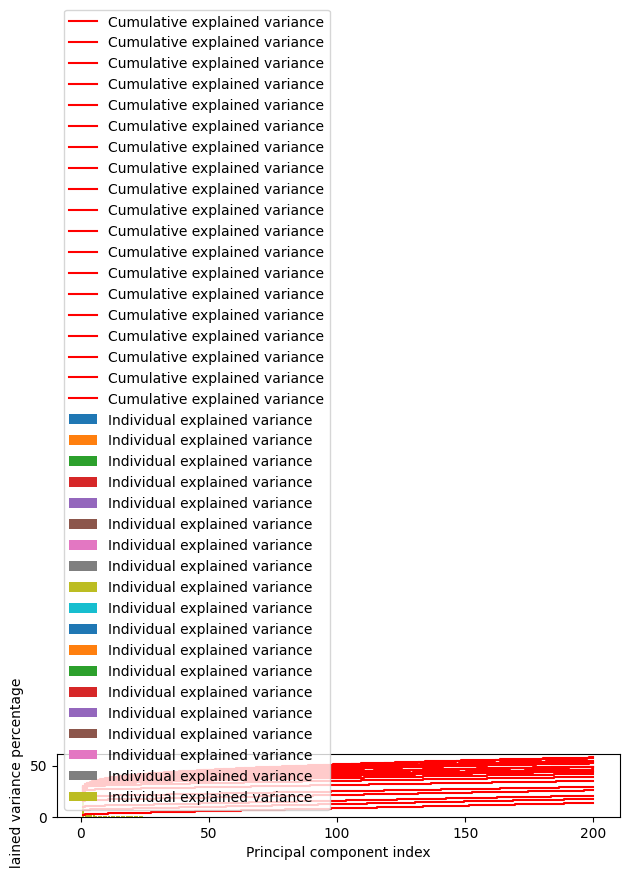

In [ ]:
# Main procedure for experiments with added noise.
# First, we define the desired array of SNR which is in the range [-25, 25] in our case.
# The chosen feature is "mfc" as the models show better accuracy with this audio feature.
# The main loop is for required SNR. During each iteration, we load data, adding noise with
# the current SNR, extract audio features, apply PCA, create datasets for training, close and open tests

feature_type = "mfc"

snr_range = [-25, -22, -20, -17, -15, -10, -5, 0, 2, 4, 6, 8, 10, 12, 15, 17, 20, 22, 25]
final_results = []
for snr in snr_range:
  X, y, z = load_data_balanced(num_samples_vector, datasets_vector, feature_type, True, snr)

  X[823].shape

  bins_number = 157
  X, y, z = adjustFeatureArrays(X, y, z, bins_number)

  # reshape 3d vector into 2d vector
  X_flattened = np.reshape(X, (X.shape[0], -1))

  print("Flattened array shape: ", X_flattened.shape)
  X_pca = applyPCA(200, X_flattened)

  excluded_fake = la_composer_id #riffusion_id      # excluded fake dataset
  excluded_real = maestro_id    # excluded real dataset

  X_ready, X_open, y_ready, y_open = split_train_from_open(X_pca, y, z, excluded_fake, excluded_real)
  # check open test split
  print(X_ready.shape, X_open.shape)

  # Split between training and test with the indicated proportion: 20% for test and 80% for training
  split = 0.2

  X_train, X_test, y_train, y_test = train_test_split(X_ready, y_ready, test_size=split, random_state=42)

  print (len(X_train), len(X_test), len(y_train), len(y_test))

  print("Close test results for SNR = ", snr)
  trained_models, close_results = close_test(X_train, y_train, X_test, y_test)
  display(close_results)

  print("Open test results for SNR = ", snr)
  open_results = open_test(X_open, y_open, trained_models)
  display(open_results)

  final_results.append([close_results, open_results])
  open_results.Classifier

In [ ]:
random_forest_close = []
random_forest_open = []
gaussian_close = []
gaussian_open = []

for result in final_results:
  close_results = result[0].values
  open_results = result[1].values

  for item in close_results:
    if item[0] == 'RandomForestClassifier':
      #float(open_results.iloc[0]['F1 Score'][0:-1])
      random_forest_close.append(float(item[1][0:-1]))
    else:
      gaussian_close.append(float(item[1][0:-1]))

  for item in open_results:
    if item[0] == 'RandomForestClassifier':
      random_forest_open.append(float(item[1][0:-1]))
    else:
      gaussian_open.append(float(item[1][0:-1]))

print("random_forest_close")
print(random_forest_close)
print("random_forest_open")
print(random_forest_open)

print("gaussian_close")
print(gaussian_close)
print("gaussian_open")
print(gaussian_open)

random_forest_close
[52.49, 61.22, 72.75, 82.91, 92.08, 95.42, 99.17, 100.0, 99.17, 98.33, 99.17, 100.0, 99.58, 100.0, 99.58, 99.58, 100.0, 100.0, 99.58]
random_forest_open
[51.47, 54.17, 56.32, 52.79, 55.39, 55.01, 53.66, 81.19, 65.27, 72.73, 68.4, 73.54, 86.0, 84.82, 89.92, 94.25, 81.16, 88.44, 85.86]
gaussian_close
[45.66, 55.83, 44.27, 78.03, 73.17, 88.69, 95.83, 98.75, 98.33, 99.17, 97.08, 98.33, 94.57, 97.5, 95.83, 93.75, 96.67, 94.58, 92.5]
gaussian_open
[44.77, 56.2, 43.58, 47.9, 38.48, 51.06, 47.96, 74.49, 67.64, 76.12, 78.5, 81.11, 86.71, 86.65, 88.13, 89.16, 89.15, 85.74, 88.87]


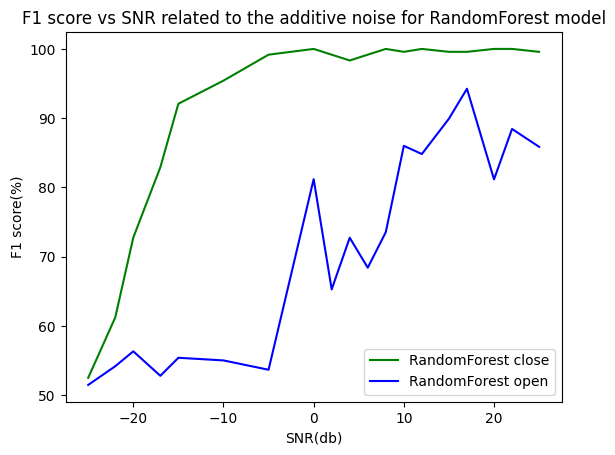

<Figure size 640x480 with 0 Axes>

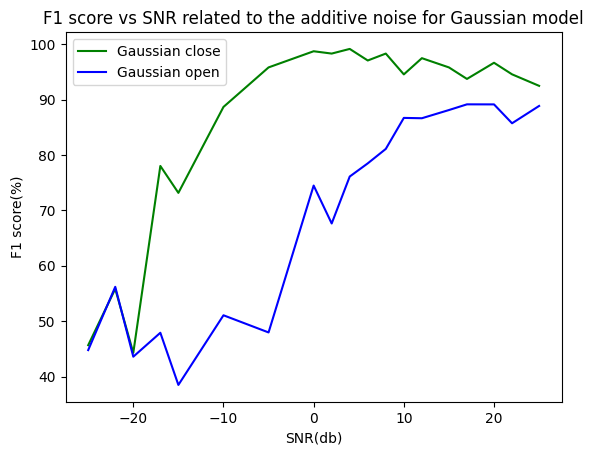

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting graphs
# Here we demonstrate how added noise affect the performance of the classifiers
# x-axis - for SNR values
# y-axis - for F1 score values

plt.figure(0)
plt.plot(snr_range, random_forest_close, 'g', label='RandomForest close')
plt.plot(snr_range, random_forest_open, 'b', label='RandomForest open')

plt.title('F1 score vs SNR related to the additive noise for RandomForest model')
plt.xlabel('SNR(db)')
plt.ylabel('F1 score(%)')
plt.legend()
plt.show()
plt.savefig("SNR_forest.png")

plt.figure(1)
plt.figure(2)
plt.plot(snr_range, gaussian_close, 'g', label='Gaussian close')
plt.plot(snr_range, gaussian_open, 'b', label='Gaussian open')

plt.title('F1 score vs SNR related to the additive noise for Gaussian model')
plt.xlabel('SNR(db)')
plt.ylabel('F1 score(%)')
plt.legend()
plt.show()
plt.savefig("SNR_gaussian.png")
